# Plotting use cases for method comparison

... and for figures in paper

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-08-06T12:02:52.409522+02:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-65-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit



In [2]:
import os

import contextily as cx
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import pandas as pd
import shapely
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from shapely.geometry import Point
from geodatasets import get_path

import core  # noqa: F401
from core import stats, utils

# %watermark -w
# %watermark -iv

In [3]:
# read in original data
# read in base data
meta = utils.read_sample_data()
meta = meta[meta.eFUA_name.isin(utils.city_fua.keys())].reset_index(drop=True)
meta

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry,continent,iso_a3
0,8989.0,4.0,11549;11569;11613;11618,Wuhan,1.0,CHN,China,2682.0,917.0,8.534061e+06,7.778941e+06,755120.113076,"POLYGON ((114.53263 30.60851, 114.52634 30.599...",Asia,CHN
1,1133.0,1.0,4417,Aleppo,1.0,SYR,Syria,1036.0,294.0,2.437709e+06,2.112719e+06,324989.970046,"POLYGON ((37.24042 36.36337, 37.25183 36.36337...",Asia,SYR
2,809.0,1.0,2850,Douala,1.0,CMR,Cameroon,360.0,224.0,3.002078e+06,2.965133e+06,36945.357264,"POLYGON ((9.60431 4.16656, 9.6143 4.16656, 9.6...",Africa,CMR
3,4617.0,1.0,670,Bucaramanga,1.0,COL,Colombia,342.0,92.0,1.054587e+06,9.526308e+05,101956.341187,"POLYGON ((-73.13881 7.24588, -73.12878 7.24588...",South America,COL
4,869.0,2.0,13129;13130,Auckland,1.0,NZL,NewZealand,2159.0,573.0,1.465958e+06,1.253144e+06,212814.292333,"POLYGON ((174.7203 -36.57421, 174.70887 -36.57...",Oceania,NZL
5,1656.0,1.0,2208,Liège,1.0,BEL,Belgium,2710.0,158.0,1.129392e+06,3.816731e+05,747718.680879,"POLYGON ((5.69383 50.88661, 5.68053 50.88661, ...",Europe,BEL
6,4881.0,1.0,193,Salt Lake City,1.0,USA,UnitedStates,1738.0,529.0,1.166374e+06,9.727146e+05,193659.830409,"POLYGON ((-111.91563 40.8034, -111.8919 40.803...",North America,USA


Finding FUA and city name for each use case

In [4]:
points = [Point(v["coords"]) for v in utils.use_cases.values()]
buffers = [v["buffer"] for v in utils.use_cases.values()]
situations = [v["situation"] for v in utils.use_cases.values()]
cases = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
cases["buffer"] = buffers
cases["city_index"] = cases.geometry.apply(
    lambda x: meta.sindex.query(x, predicate="intersects")
)
cases["fua"] = cases.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))
cases["city"] = cases.city_index.apply(lambda x: meta.iloc[x[0]]["eFUA_name"])
cases = cases.drop(columns=["city_index"])
cases["case_id"] = cases.index
cases["situation"] = situations
cases

/tmp/ipykernel_22117/3186524579.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cases["fua"] = cases.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))


,geometry,buffer,fua,city,case_id,situation
0,POINT (9.81981 4.00249),220,809,Douala,0,Parallel edges
1,POINT (9.82132 4.00986),100,809,Douala,1,Roundabouts
2,POINT (37.06837 36.31436),200,1133,Aleppo,2,Diverging streets
3,POINT (174.7512 -36.88972),100,869,Auckland,3,T-junction
4,POINT (37.06599 36.31055),120,1133,Aleppo,4,Simple intersection
5,POINT (9.74106 4.09687),80,809,Douala,5,Cross-shaped intersection
6,POINT (37.1427 36.23658),30,1133,Aleppo,6,Intersection
7,POINT (37.13986 36.24012),220,1133,Aleppo,7,Side edges
8,POINT (5.63148 50.60589),110,1656,Liège,8,Cul-de-sac
9,POINT (37.16807 36.19395),130,1133,Aleppo,9,Ovalabout


In [5]:
cases.loc[10, "buffer"] = 500

In [6]:
# which methods to import
methods = [
    "original",
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
    "manual",
]

Define plot parameters for markers

In [7]:
marker_params_original = {
    0: {"facecolor": "k", "edgecolor": "k", "markersize": 2},
    1: {"facecolor": "lightgrey", "edgecolor": "k", "markersize": 25},
}

marker_params_simplified = {
    0: {"facecolor": "k", "edgecolor": "k", "markersize": 2},
    1: {"facecolor": "lightgrey", "edgecolor": "k", "markersize": 25},
}

marker_params = {"original": marker_params_original}

for method in methods:
    marker_params[method] = marker_params_simplified.copy()

Read in data

In [8]:
### READ IN DATA

# initiate dicts
geoms = {}
projs = {}

# per city
for fua, city in utils.fua_city.items():
    print(city)

    geoms[city] = {}

    # poly = meta.loc[meta.eFUA_ID == fua, "geometry"]

    gdf_orig = utils.read_original(fua)
    proj_crs = gdf_orig.crs
    projs[fua] = proj_crs

    # per method
    for method in methods:
        print(f"\t {method}...")
        gdf = utils.read_results(fua, method, proj_crs)
        gdf = gdf[~gdf.normalize().duplicated()].copy().reset_index(drop=True)

        # get graph
        G = momepy.gdf_to_nx(gdf, length="length", integer_labels=True)

        nodes, edges = momepy.nx_to_gdf(G)
        nodes = stats.add_node_degree(nodes, G)

        geoms[city][method] = {}
        geoms[city][method]["lines"] = edges.copy()
        geoms[city][method]["vertices"] = nodes.copy()
        geoms[city][method]["graph"] = G.copy()


# add proj_crs info to cases table
cases["proj_crs"] = cases.fua.apply(lambda x: projs[x])

Aleppo
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Auckland
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Bucaramanga
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Douala
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Liège
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Salt Lake City
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...
Wuhan
	 original...
	 cityseer...
	 osmnx...
	 parenx-voronoi...
	 parenx-skeletonize...
	 neatnet...
	 manual...


***

## Separate situatiation plots for appendix (cf table)


In [56]:
situations_fp = "../../plots/situations/"
os.makedirs(situations_fp, exist_ok=True)

In [11]:
for _, mycase in cases.iterrows():
    proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
    myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)

    fig, axs = plt.subplots(1, len(methods), figsize=(25, 10), sharex=True, sharey=True)

    for ax, method in zip(axs, methods, strict=False):
        # clip lines and vertices to zoom window
        lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
        vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()

        # plot lines
        lines.plot(
            ax=ax,
            linewidth=2,
            linestyle="-",
            zorder=1,
            color=utils.method_color[method],
        )
        # plot vertices
        if not vertices[vertices["degree"] == 2].empty:
            vertices[vertices["degree"] == 2].plot(
                ax=ax,
                facecolor=marker_params[method][0]["facecolor"],
                edgecolor=marker_params[method][0]["edgecolor"],
                markersize=marker_params[method][0]["markersize"],
                zorder=2,
            )
        vertices[vertices["degree"] != 2].plot(
            ax=ax,
            facecolor=marker_params[method][1]["facecolor"],
            edgecolor=marker_params[method][1]["edgecolor"],
            markersize=marker_params[method][1]["markersize"],
            zorder=3,
        )

        # add ylabel to original (leftmost column)
        if method == "original":
            ax.set_ylabel(
                mycase.situation,
                rotation=90,
                fontsize=12,
                multialignment="center",
                x=-0.02,
            )
            # hide all axis elements except y-label of original
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_ticks([])
            ax.spines[:].set_visible(False)
        elif method == "manual":
            pt = proj_coord.to_crs(4326).iloc[0]
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                f"lat: {round(pt.y, 4)}\nlng: {round(pt.x, 4)}\n({mycase.city})",
                rotation=90,
                # fontsize=12,
                multialignment="center",
                x=0.02,
            )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_ticks([])
            ax.spines[:].set_visible(False)
        else:
            ax.set_axis_off()

        # add method as title to each subfigure
        ax.set_title(
            method,
            fontsize=16,
        )

    plt.tight_layout()
    # plt.show()
    fig.savefig(
        situations_fp + f"{mycase.case_id:02}_allmethods.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Use case {mycase.case_id} plotted & saved.")
    plt.close()

Use case 0 plotted & saved.
Use case 1 plotted & saved.
Use case 2 plotted & saved.
Use case 3 plotted & saved.
Use case 4 plotted & saved.
Use case 5 plotted & saved.
Use case 6 plotted & saved.
Use case 7 plotted & saved.
Use case 8 plotted & saved.
Use case 9 plotted & saved.
Use case 10 plotted & saved.
Use case 11 plotted & saved.
Use case 12 plotted & saved.
Use case 13 plotted & saved.
Use case 14 plotted & saved.
Use case 15 plotted & saved.
Use case 16 plotted & saved.
Use case 17 plotted & saved.
Use case 18 plotted & saved.


***
**Figure with 6 use cases for main text**

In [9]:
# select 6 use cases
j = [5, 3, 6, 13, 4, 9]

Use case 5
Use case 3
Use case 6
Use case 13
Use case 4
Use case 9


/tmp/ipykernel_202021/482114923.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


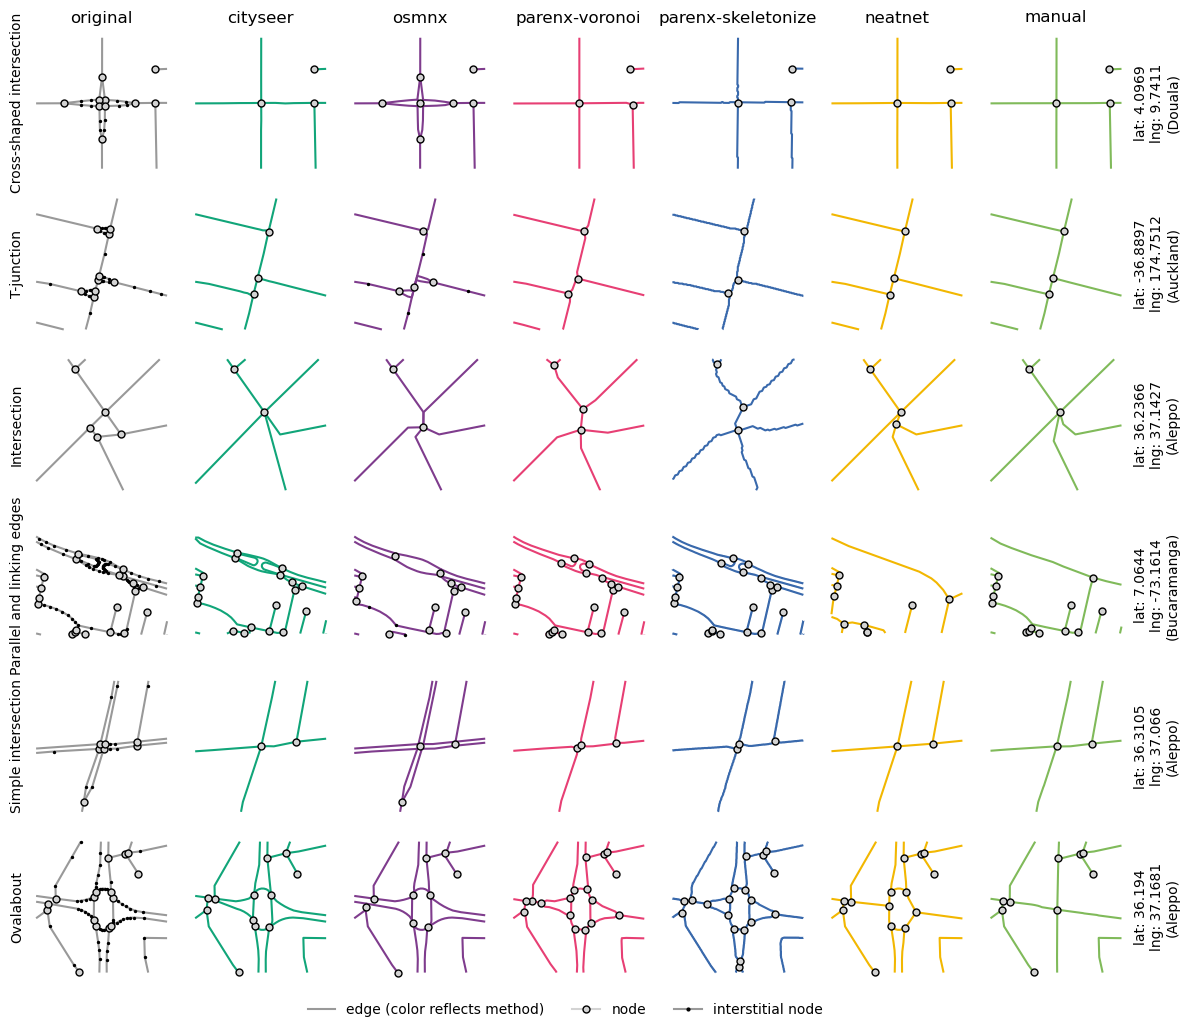

In [22]:
# make figure
fig, axs = plt.subplots(
    len(j),
    len(methods),
    figsize=(12, 10),
)

for i, mycase in cases.iloc[j].reset_index(drop=True).iterrows():
    print(f"Use case {mycase.case_id}")
    proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
    myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)
    for k, method in enumerate(methods):
        ax = axs[i, k]
        lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
        vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
        lines.plot(
            ax=ax,
            linewidth=1.5,
            linestyle="-",
            zorder=1,
            color=utils.method_color[method],
        )
        # plot vertices
        if not vertices[vertices["degree"] == 2].empty:
            vertices[vertices["degree"] == 2].plot(
                ax=ax,
                facecolor=marker_params[method][0]["facecolor"],
                edgecolor=marker_params[method][0]["edgecolor"],
                markersize=marker_params[method][0]["markersize"],
                zorder=2,
            )
        vertices[vertices["degree"] != 2].plot(
            ax=ax,
            facecolor=marker_params[method][1]["facecolor"],
            edgecolor=marker_params[method][1]["edgecolor"],
            markersize=marker_params[method][1]["markersize"],
            zorder=3,
        )

        # add subplot titles to upper row
        if i == 0:
            ax.set_title(method)

        # add ylabels to leftmost column
        if method == "original":
            ax.set_ylabel(
                mycase.situation,
                rotation=90,
                # fontsize=12,
                multialignment="center",
                x=0.02,
            )
            # hide all axis elements except y-label of original
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_ticks([])
            ax.spines[:].set_visible(False)
        elif method == "manual":
            ax2 = ax.twinx()
            pt = proj_coord.to_crs(4326).iloc[0]
            ax2.set_ylabel(
                f"lat: {round(pt.y, 4)}\nlng: {round(pt.x, 4)}\n({mycase.city})",
                rotation=90,
                # fontsize=12,
                multialignment="center",
                x=0.02,
            )
            ax2.get_xaxis().set_visible(False)
            ax2.get_yaxis().set_ticks([])
            ax2.spines[:].set_visible(False)
            ax.set_axis_off()
        else:
            ax.set_axis_off()

legend_elements = [
    Line2D(
        [0],
        [0],
        color=utils.method_color["original"],
        lw=1.5,
        label="edge (color reflects method)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="lightgrey",
        markeredgecolor="k",
        markersize=5,
        label="node",
        lw=1.5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=utils.method_color["original"],
        markerfacecolor="k",
        markeredgecolor=marker_params[method][0]["edgecolor"],
        markersize=marker_params[method][0]["markersize"],
        label="interstitial node",
        lw=1.5,
    ),
]

# Add legend to the plot
# Create a new axis below the entire figure for the legend
legend_ax = fig.add_axes([0.1, -0.03, 0.75, 0.03])  # [left, bottom, width, height]
legend_ax.axis("off")  # Turn off the axis

# Add the legend to the new axis
legend_ax.legend(
    handles=legend_elements,
    loc="center",
    frameon=False,
    ncol=6,
)

plt.tight_layout()

fig.savefig(
    situations_fp + "fig_situations-selection.png", dpi=300, bbox_inches="tight"
)

plt.show()

***

## Figure 1 (manual vs simplified), Liège 

In [13]:
use_case = {
    0: {
        "coords": (5.519019, 50.606610),
        "buffer": 555,
    },
}

In [14]:
points = [Point(v["coords"]) for v in use_case.values()]
buffers = [v["buffer"] for v in use_case.values()]
cases_fig1 = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
cases_fig1["buffer"] = buffers
cases_fig1["city_index"] = cases_fig1.geometry.apply(
    lambda x: meta.sindex.query(x, predicate="intersects")
)
cases_fig1["fua"] = cases_fig1.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))
cases_fig1["city"] = cases_fig1.city_index.apply(lambda x: meta.iloc[x[0]]["eFUA_name"])
cases_fig1 = cases_fig1.drop(columns=["city_index"])
cases_fig1["case_id"] = cases_fig1.index
cases_fig1["proj_crs"] = cases_fig1.fua.apply(lambda x: projs[x])
cases_fig1

/var/folders/66/3jkth_7d5gggg6pyr8yywwt40000gn/T/ipykernel_16411/2270713484.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cases_fig1["fua"] = cases_fig1.city_index.apply(lambda x: int(meta.iloc[x]["eFUA_ID"]))


,geometry,buffer,fua,city,case_id,proj_crs
0,POINT (5.51902 50.60661),555,1656,Liège,0,"{""$schema"": ""https://proj.org/schemas/v0.7/pro..."


Figure 1 without nodes

In [15]:
# m = 0
# mycase = cases_fig1.loc[m]

# print(f"Use case {mycase.case_id}")

# proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
# myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)

# fig, axs = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)

# # left side: original
# ax = axs[0]
# method = "original"

# lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
# vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
# lines.plot(
#     ax=ax,
#     linewidth=1.5,
#     linestyle="-",
#     zorder=1,
#     #    color=utils.method_color[method],
#     color="k",
# )
# ax.set_title(
#     "Transporation-focused original network",
#     fontsize=32,
# )

# # right side: manual
# method = "manual"
# ax = axs[1]
# lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
# vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
# lines.plot(
#     ax=ax,
#     linewidth=2,
#     linestyle="-",
#     zorder=1,
#     color=utils.method_color[method],
# )
# ax.set_title(
#     "Manually simplified network",
#     fontsize=32,
# )

# for ax in axs:
#     ax.set_axis_off()
#     ax.set_xlim(lines.total_bounds[0] - 10, lines.total_bounds[2] - 15)
#     ax.set_ylim(lines.total_bounds[1] - 10, lines.total_bounds[3] - 100)
#     cx.add_basemap(ax=ax, source="cartodb.positronnolabels", crs=lines.crs)

# plt.tight_layout()
# plt.show()
# # fig.savefig(situations_fp + f"comp{mycase.case_id}.png", dpi=300)

***

## Figure 1 with buildings (final version)

Use case 0


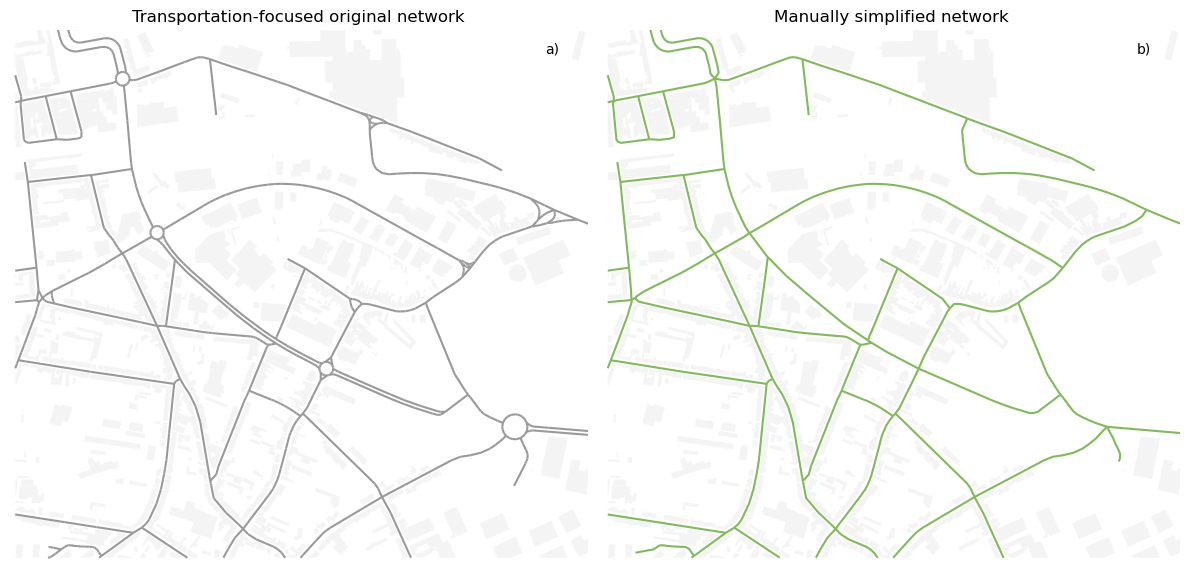

In [16]:
# subplot params
lw = 1.5  # line width
fs = 15  # font size of title

m = 0
mycase = cases_fig1.loc[m]

print(f"Use case {mycase.case_id}")

proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# left side: original
ax = axs[0]
method = "original"

lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
buildings = gpd.read_parquet(f"../../data/{mycase.fua}/buildings/buildings.parquet")
buildings = buildings.to_crs(lines.crs)
buildings = buildings.clip(myzoom)

lines.plot(
    ax=ax,
    linewidth=lw,
    linestyle="-",
    zorder=1,
    color=utils.method_color[method],
)
ax.set_title(
    "Transportation-focused original network",
    # fontsize=fs,
)

# right side: manual
method = "manual"
ax = axs[1]
lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
lines.plot(
    ax=ax,
    linewidth=lw,
    linestyle="-",
    zorder=1,
    color=utils.method_color[method],
)
ax.set_title(
    "Manually simplified network",
    # fontsize=fs,
)

for ax in axs:
    ax.set_axis_off()
    ax.set_xlim(lines.total_bounds[0] - 10, lines.total_bounds[2] - 15)
    ax.set_ylim(lines.total_bounds[1] - 10, lines.total_bounds[3] - 100)
    buildings.plot(ax=ax, color="lightgrey", alpha=0.23)

for i, lab in enumerate(["a)", "b)"]):
    axs[i].text(
        0.95,
        0.95,
        lab,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=axs[i].transAxes,
        # fontsize=32,
    )


plt.tight_layout()
plt.show()
fig.savefig(situations_fp + "fig_original-manual.png", dpi=300, bbox_inches="tight")

***

Past use case explorations

In [17]:
# city = "Douala"
# m = geoms[city]["original"]["lines"].explore(tiles="cartodb.positron", name = "original", color = "black")
# for method in ["neatnet", "manual"]:
#     geoms[city][method]["lines"].explore(m=m, color = utils.method_color[method], name=method)
# folium.LayerControl().add_to(m)
# m

# use_cases = {
#     0: {
#         "coords": (-111.871247, 40.718748),
#         "buffer": 220,
#     },
#     1: {
#         "coords": (5.519019, 50.606610),
#         "buffer": 555,
#     },
#     2: {
#         "coords": (9.706190326301792, 4.064858980749481),
#         "buffer": 450,
#     },
#     3: {
#         "coords": (9.77168420506175, 4.080808228350037),
#         "buffer": 400,
#     },
# }


In [18]:
# m = 0
# mycase = cases_fig1.loc[m]


# print(f"Use case {mycase.case_id}")

# proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(
#     mycase.proj_crs
# )
# myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)

# fig, axs = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)

# # left side: original
# ax = axs[0]
# method = "original"

# lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
# vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
# lines.plot(
#     ax=ax,
#     linewidth=1.5,
#     linestyle="-",
#     zorder=1,
#     color=utils.method_color[method],
#     label = "Edges"
# )
# # plot vertices
# if not vertices[vertices["degree"]==2].empty:
#     vertices[vertices["degree"]==2].plot(
#         ax=ax,
#         facecolor=marker_params[method][0]["facecolor"],
#         edgecolor=marker_params[method][0]["edgecolor"],
#         markersize=marker_params[method][0]["markersize"],
#         zorder=2,
#         label = r"Nodes (degree $d \eq 2$)"
#     )
# vertices[vertices["degree"]!=2].plot(
#     ax=ax,
#     facecolor=marker_params[method][1]["facecolor"],
#     edgecolor=marker_params[method][1]["edgecolor"],
#     markersize=marker_params[method][1]["markersize"],
#     zorder=3,
#     label = r"Nodes (degree $d \neq 2$)"
# )

# ax.set_axis_off()
# # add method as title to each subfigure
# ax.set_title(
#     "Transporation-focused original network",
#     fontsize=32,
# )
# ax.legend(fontsize=18, markerscale = 1.5)

# # right side: manual
# method = "manual"
# ax = axs[1]
# lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
# vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()
# lines.plot(
#     ax=ax,
#     linewidth=2,
#     linestyle="-",
#     zorder=1,
#     color=utils.method_color[method],
#     label = "Edges"
# )
# # plot vertices
# if not vertices[vertices["degree"]==2].empty:
#     vertices[vertices["degree"]==2].plot(
#         ax=ax,
#         facecolor=marker_params[method][0]["facecolor"],
#         edgecolor=marker_params[method][0]["edgecolor"],
#         markersize=marker_params[method][0]["markersize"],
#         zorder=2,
#         label = r"Nodes (degree $d \eq 2$)"
#     )
# vertices[vertices["degree"]!=2].plot(
#     ax=ax,
#     facecolor=marker_params[method][1]["facecolor"],
#     edgecolor=marker_params[method][1]["edgecolor"],
#     markersize=marker_params[method][1]["markersize"],
#     zorder=3,
#     label = r"Nodes (degree $d \neq 2$)"

# )

# # vertices.plot(
# #     ax=ax,
# #     facecolor=marker_params[method][]["facecolor"],
# #     edgecolor=marker_params[method]["edgecolor"],
# #     markersize=marker_params[method]["markersize"],
# #     zorder=2,
# #     label = "Nodes"
# # )
# ax.set_axis_off()
# ax.set_title(
#     "Manually simplified network",
#     fontsize=32,
# )
# ax.legend(fontsize=18, markerscale = 1.5)
# ax.set_xlim(lines.total_bounds[0]-10,lines.total_bounds[2]-15)
# ax.set_ylim(lines.total_bounds[1]-10,lines.total_bounds[3]-100)
# plt.tight_layout()
# plt.show()
# # fig.savefig(situations_fp + f"comp{mycase.case_id}.png", dpi=300)

# "Big methods" figure for appendix

In [63]:
methods_plotorder = [
    "original",
    "cityseer",
    "osmnx",
    "parenx-skeletonize",
    "parenx-voronoi",
    "neatnet",
    "manual",
]

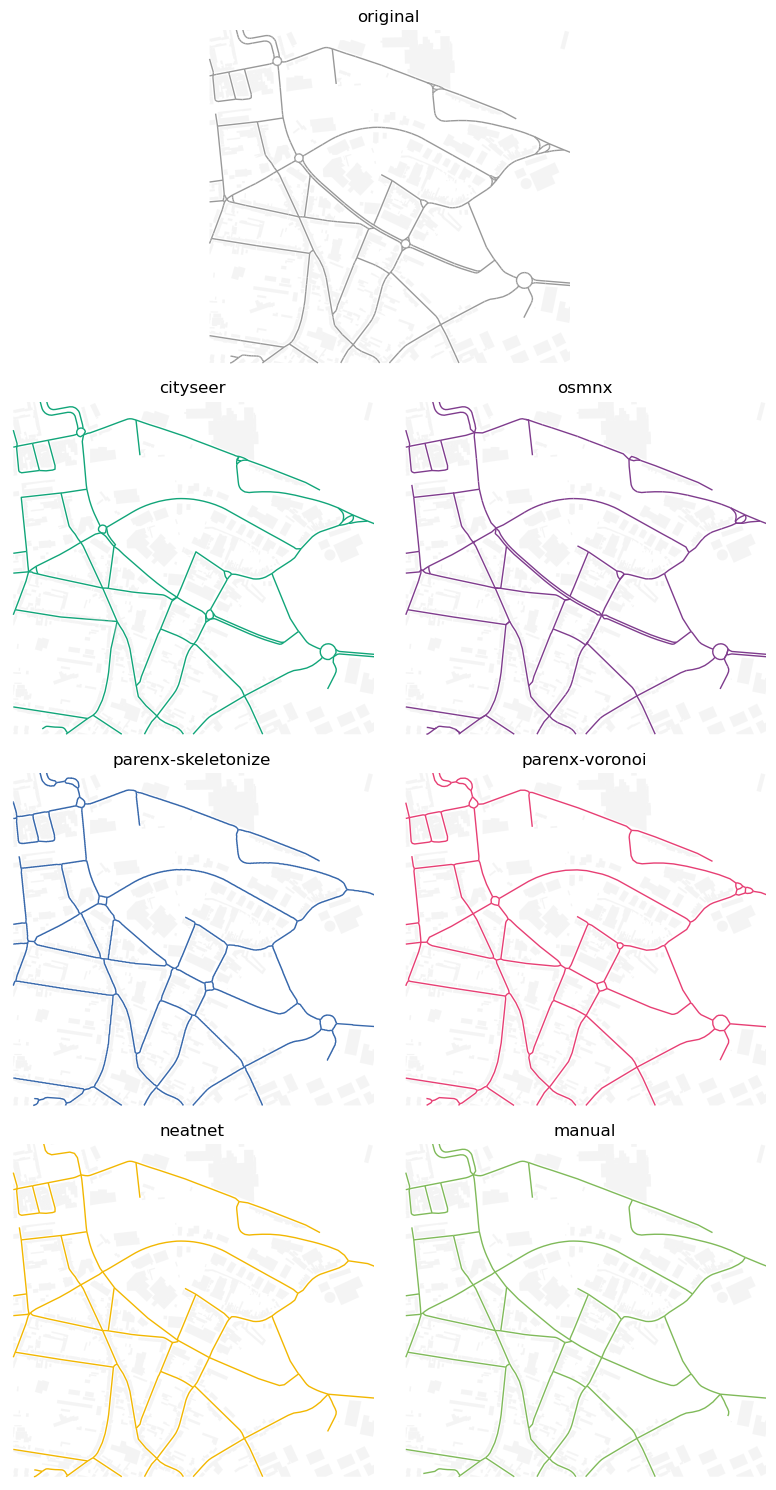

In [19]:
# subplot params
lw = 1
m = 0
mycase = cases_fig1.loc[m]

proj_coord = gpd.GeoSeries(mycase.geometry, crs=cases.crs).to_crs(mycase.proj_crs)
myzoom = proj_coord.buffer(mycase.buffer, cap_style=3)

buildings = gpd.read_parquet(f"../../data/{mycase.fua}/buildings/buildings.parquet")
buildings = buildings.to_crs(lines.crs)
buildings = buildings.clip(myzoom)


fig = plt.figure(
    # layout="constrained",
    figsize=(8, 15)
)
gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 2:4])
ax4 = fig.add_subplot(gs[2, 0:2])
ax5 = fig.add_subplot(gs[2, 2:4])
ax6 = fig.add_subplot(gs[3, 0:2])
ax7 = fig.add_subplot(gs[3, 2:4])

axes_plotorder = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for ax, method in zip(axes_plotorder, methods_plotorder, strict=False):
    lines = geoms[mycase.city][method]["lines"].clip(myzoom).copy()
    vertices = geoms[mycase.city][method]["vertices"].clip(myzoom).copy()

    lines.plot(
        ax=ax,
        linewidth=lw,
        linestyle="-",
        zorder=1,
        color=utils.method_color[method],
    )
    ax.set_title(
        method,
    )

    ax.set_axis_off()
    ax.set_xlim(lines.total_bounds[0] - 10, lines.total_bounds[2] - 15)
    ax.set_ylim(lines.total_bounds[1] - 10, lines.total_bounds[3] - 100)
    buildings.plot(ax=ax, color="lightgrey", alpha=0.23)

plt.tight_layout()
plt.show()
fig.savefig(situations_fp + "fig_allmethods.png", dpi=300, bbox_inches="tight")

# Examples from all cases

In [25]:
meta

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry,continent,iso_a3
0,8989.0,4.0,11549;11569;11613;11618,Wuhan,1.0,CHN,China,2682.0,917.0,8.534061e+06,7.778941e+06,755120.113076,"POLYGON ((114.53263 30.60851, 114.52634 30.599...",Asia,CHN
1,1133.0,1.0,4417,Aleppo,1.0,SYR,Syria,1036.0,294.0,2.437709e+06,2.112719e+06,324989.970046,"POLYGON ((37.24042 36.36337, 37.25183 36.36337...",Asia,SYR
2,809.0,1.0,2850,Douala,1.0,CMR,Cameroon,360.0,224.0,3.002078e+06,2.965133e+06,36945.357264,"POLYGON ((9.60431 4.16656, 9.6143 4.16656, 9.6...",Africa,CMR
3,4617.0,1.0,670,Bucaramanga,1.0,COL,Colombia,342.0,92.0,1.054587e+06,9.526308e+05,101956.341187,"POLYGON ((-73.13881 7.24588, -73.12878 7.24588...",South America,COL
4,869.0,2.0,13129;13130,Auckland,1.0,NZL,NewZealand,2159.0,573.0,1.465958e+06,1.253144e+06,212814.292333,"POLYGON ((174.7203 -36.57421, 174.70887 -36.57...",Oceania,NZL
5,1656.0,1.0,2208,Liège,1.0,BEL,Belgium,2710.0,158.0,1.129392e+06,3.816731e+05,747718.680879,"POLYGON ((5.69383 50.88661, 5.68053 50.88661, ...",Europe,BEL
6,4881.0,1.0,193,Salt Lake City,1.0,USA,UnitedStates,1738.0,529.0,1.166374e+06,9.727146e+05,193659.830409,"POLYGON ((-111.91563 40.8034, -111.8919 40.803...",North America,USA


In [26]:
utils.method_color

{'original': '#999999',
 'cityseer': '#11A579',
 'osmnx': '#7F3C8D',
 'parenx-voronoi': '#E73F74',
 'parenx-skeletonize': '#3969AC',
 'neatnet': '#F2B701',
 'neatnet-buildings': '#008695',
 'manual': '#80BA5A'}

In [9]:
insets = {
    "Douala": (578539, 446273),
    'Auckland': (300370, -4081691),
    'Aleppo': (335269, 4007029),
    'Liège': (682866, 5613230),
    'Bucaramanga': (707829, 787105),
    'Salt Lake City': (424899, 4512706),
    'Wuhan': (236184, 3390290)
}

In [12]:
world = gpd.read_file(get_path('naturalearth land')).to_crs('+proj=moll')

In [53]:
meta.loc[4, 'Cntry_name'] = 'New Zealand'
meta.loc[6, 'Cntry_name'] = 'USA'

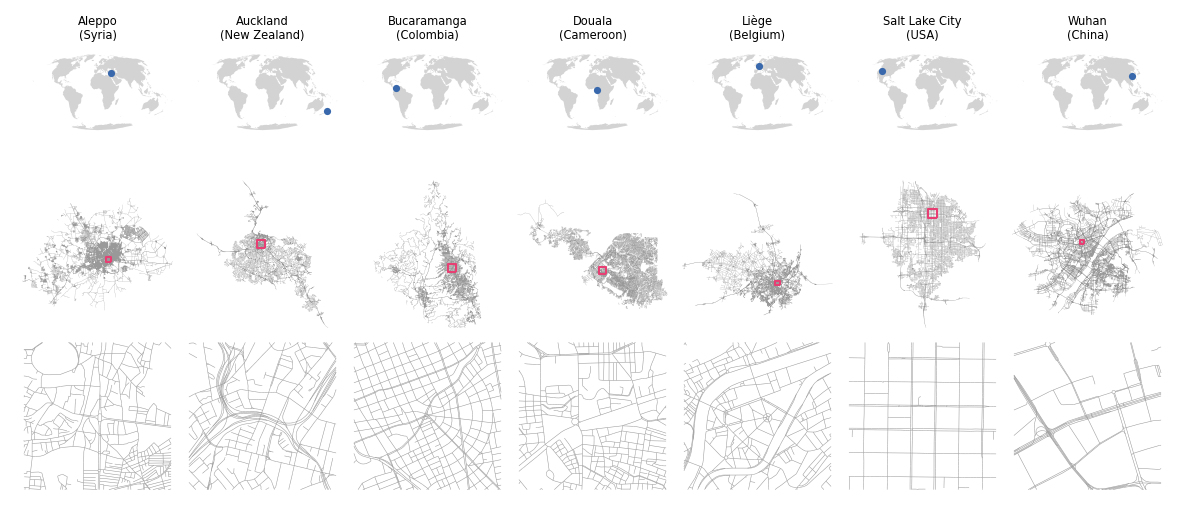

In [76]:
fig, axs = plt.subplots(3, 7, figsize=(8, 3.7), dpi=150)

zoom = 750

for i, city in enumerate(meta.eFUA_name.sort_values()):
    geoms[city]['original']['lines'].plot(ax=axs[1, i], color=utils.method_color['original'], linewidth=.1)
    axs[0, i].set_title(f"{city}\n({meta[meta.eFUA_name == city].Cntry_name.item()})", fontsize=5.5)
    x, y = insets[city]
    box = shapely.box(x-zoom, y-zoom, x+zoom, y+zoom)
    geoms[city]['original']['lines'].clip(box).plot(ax=axs[2, i], color=utils.method_color['original'], linewidth=.25)
    gpd.GeoSeries([box]).boundary.plot(ax=axs[1, i], color='#E73F74', linewidth=1)

    world.plot(color='lightgray', ax=axs[0, i])
    meta[meta.eFUA_name == city].representative_point().to_crs('+proj=moll').plot(ax=axs[0, i], markersize=6, color="#3969AC")

    # _ = inset_locator.mark_inset(axs[1, i], axs[2, i], loc1=1, loc2=2, edgecolor='k', linewidth=.5, facecolor='none')


for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()
fig.subplots_adjust(wspace = 0.00, hspace=0.00)
fig.savefig(situations_fp + "fig-all-cases.png", dpi=300, bbox_inches="tight")

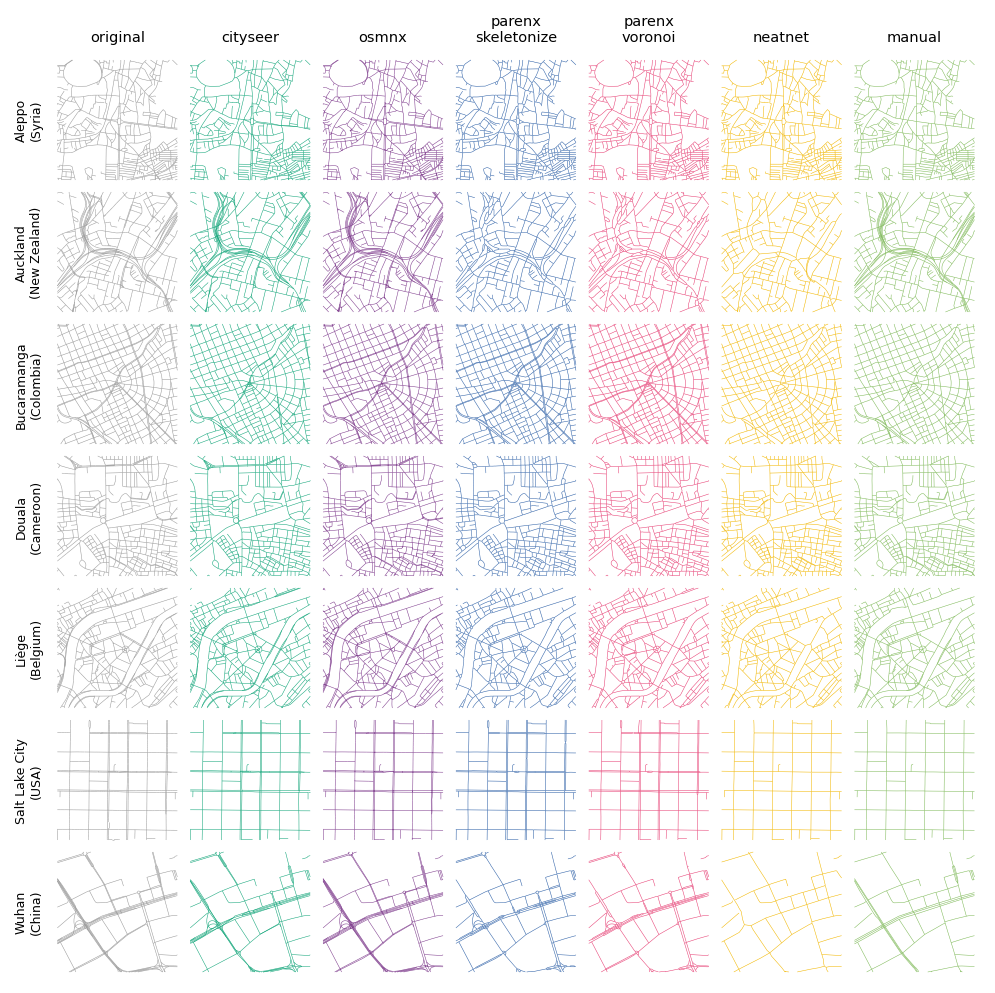

In [83]:
fig, axs = plt.subplots(7, 7, figsize=(8, 8), dpi=150)

for i, city in enumerate(meta.eFUA_name.sort_values()):
    for j, method in enumerate(methods_plotorder):
        x, y = insets[city]
        box = shapely.box(x-zoom, y-zoom, x+zoom, y+zoom)
        gdf = geoms[city][method]['lines'].clip(box)
        # cityseer somehow returns two points...
        gdf[gdf.geom_type != "Point"].plot(ax=axs[i, j], color=utils.method_color[method], linewidth=.25)    


        # add subplot titles to upper row
        if i == 0:
            axs[i, j].set_title(method.replace('-', '\n'), fontsize=7, y=1)
    
        # add ylabels to leftmost column
        if method == "original":
            axs[i, j].set_ylabel(
                f"{city}\n({meta[meta.eFUA_name == city].Cntry_name.item()})",
                rotation=90,
                fontsize=6,
                multialignment="center",
                x=0.02,
            )
            # hide all axis elements except y-label of original
            axs[i, j].get_xaxis().set_visible(False)
            axs[i, j].get_yaxis().set_ticks([])
            axs[i, j].spines[:].set_visible(False)
        else:
            axs[i, j].set_axis_off()
        
fig.subplots_adjust(wspace = 0.00, hspace=0.00)
fig.savefig(situations_fp + "fig-all-results.png", dpi=300, bbox_inches="tight")

In [80]:
city = 'Douala'
method = 'cityseer'
x, y = insets[city]
box = shapely.box(x-zoom, y-zoom, x+zoom, y+zoom)
gdf = geoms[city][method]['lines'].clip(box)

In [82]:
gdf.geom_type.value_counts()

LineString         636
MultiLineString      2
Point                2
Name: count, dtype: int64